### Example Notebook to bench test all the pieces and make improvements for tuning repeatability. Also should serve as a first order walkthrough of the process for demonstrations (Results may vary)

##### Probabalistic Demonstration of A Bayesian Changepoint analysis, Inncluding correlation and a forecasting solution Animation

#### Goals:
###### Take a number of generatied well logs from a basin model, and identify changepoints and data trends that will be used to infer property changes and characterize the subsurface. Follow this charaterization by simulating a 'new' drilling campaign where a 'well' will be drilled at a random point in the model and then similarly analysed for changepoints in a time stepped manner to simulate a real-time analysis, as if it were performed concurrently during the drilling. This new information will be used for forecasting property changes that will occur 'ahead of the bit' during this new drilling campaign. 

#### Outline:
###### A function has been prepared to simulate the all boreholes in a simple synthetic graben model, Lisa's that is available from the example models from GemPy. 4 wells have been drilled in four quadrants in this model and two additional investigation boreholes will be chosen at random. A 7th well will be simulated and its depth will be contrainted to between 1000 meters and the bottom of the model so that it provides a sensible amount of data to forecast with. This notebook will outline the Framework to these forecasts and attempts to predict probabilities of property changes from the 7th drilling campaigns; An animation will simulating the forecasts obtained while drilling this well by incremetally adding data to the input well and running the analysis for each depth (time) step.


#### Animation:

###### The last cell in this notebook will create a 100 frame sequential animation of the drilling simulation and the prediction output.

###### _Some background info... and nomenclature. I've decided to use the vernacular 'CompariTEE' and 'CompariTOR' to describe the Unknown and known wells, if only to capitalize on the neumonic *Prior/Tor* as it really could have gone either way._

###### _Comparitor ('priors') wells:_
###### _Comparitee (investigation) wells:_ 


###### adam jones 04.09.23

In [2]:
'''Loading dependencies''' 
#included in root $different_bayes$ git folder is a *.yml that will create a juptyer ENV to run this with
#called 'different_bayes_juptyer_environment.yml'

import sys
sys.path.append('..\\..\\src')

import matplotlib.pyplot as plt
import numpy as np
#import ruptures as rpt
import welly
import pandas as pd
import scipy.stats as stats
import gempy as gp
import sdt

#Collections of self built methods
import cp_comparitor as cp_Comp
import change_point_tools as cp_Tools
import well_tools as wtool


# This is a function testing module
#import test_func as tst

No module named 'osgeo'


#### Building graben model and simulating well data 

In [3]:
'''Path to data'''
#path = '..\\..\\data\\raw\\

'Path to data'

In [4]:

# Drilling class
class well_from_graben_model(object):
    
    ''' This class has only one job and this is to toss out synthetic well logs for a gempy graben model: (Lisa's Model specifically)
    Density (RHO) and Porosity (PHI) are populated based on the lithology codes from the vertical borings

    By changeing the __init__ function and replacing the existing GemPy computation with a different model should allow
    this class to extend to other models. This class should likely be extended to allow a GemPy model as an input rather
    than re-computing the model upon each call.
    
    Pro Tip!
    The compute_model function will bork without any additional values populated in the surface values, for reasons 
    that I am not sure of... some additonal features are built in the model, like sections and this was due to 
    previous attempts at creating well logs from 2D sections, which are still being worked with.
    
    Parameters:
        x : map section x position of sample (boring)
        y : map section y position of sample (boring)
        z_top : This is the top of the boring (nearer to the surface)
        z_bottom : This is the bottom of the boring (near the 'basement')
        res : Resolution of the log (number of equidistant samples)
        Rnoise : RHO (density) noise sigma (stdDev) for the convolution step (random normal, using the true value as mu)
        Pnoise : PHI (porosity) noise sigma
    '''
    
    def __init__(self, x, y, z_top, z_bottom, res, Rnoise, Pnoise):
        
        self.x = x
        self.y = y
        self.z_top = z_top
        self.z_bottom = z_bottom
        self.res = res
        self.Rnoise = Rnoise
        self.Pnoise = Pnoise
        #self.return_well = self.return_well(self.wellpath, self.welldata)
        #self.phi_rho = self.phi_rho
        #self.build_1d_well_path = self.build_1d_well_path
        
        data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'

        geo_model = gp.create_data('viz_3d',
                           [0, 2000, 0, 2000, 0, 1600],
                           [50, 50, 50],
                           path_o=data_path + "data/input_data/lisa_models/foliations" + str(
                               7) + ".csv",
                           path_i=data_path + "data/input_data/lisa_models/interfaces" + str(
                               7) + ".csv"
                                )

        gp.map_stack_to_surfaces(geo_model,
                                {"Fault_1": 'Fault_1', "Fault_2": 'Fault_2',
                                 "Strat_Series": ('Sandstone', 'Siltstone', 'Shale', 'Sandstone_2', 'Schist', 'Gneiss')}
                                )
        geo_model.add_surface_values([[0,0,.2, .3, .4, .2, .1, 0.03, .0], [0,0,2.1, 2, 1.8, 2.1, 2.4, 2.5, 2.9]], ['porosity', 'bulk_density'])
        geo_model.set_is_fault(['Fault_1', 'Fault_2'])
        section_dict = {'well1': ([100, 500], [100, 1100], [20, 20]), 'well2': ([10,2000],[2000,10],[100,100])
                }
        geo_model.set_section_grid(section_dict)
        #gp.plot.plot_section_traces(geo_model)
        geo_model.get_active_grids()
        #gp.set_interpolator(geo_model, theano_optimizer='fast_compile')
        #geo_model.get_active_grids()
        self.well_path = self.build_1d_well_path(x, y, z_top, z_bottom, res)
        print(self.well_path[:4])
        geo_model.get_active_grids()
        
        gp.set_interpolator(geo_model, theano_optimizer='fast_compile')
        
        sol = gp.compute_model(geo_model, at=self.well_path)
        self.well_data = self.phi_rho(sol, self.Rnoise, self.Pnoise)
        print(self.well_data[:1])
        #self.return_well(self.well_path, self.well_data)
        
        #return self.well_path, self.well_data
    #if __name__ == '__main__':
    
    def build_1d_well_path(self, x, y, z_top, z_bottom, res): #z_bottom and z_top are relative to a lower model boundary (basement) zero point, which puts the surface closer to zero 
        x = np.ones(res)*x
        y = np.ones(res)*y
        z = np.linspace(z_bottom , z_top, res)
        #well_path1 = np.empty(3)

        for i in range(res):
            if i == 0:
                well_path= np.array((x[0],y[0],z[0]))
            else:
                well_path = np.vstack((well_path, np.array((x[i],y[i],z[i]))), dtype=object)
        return well_path

    def phi_rho(self, sol, Rnoise, Pnoise):
        phi = []
        rho = []
        phiRho = np.vstack(([0,0,0,.2, .3, .4, .2, .1, 0.03, .0], [0,0,0,2.1, 2, 1.8, 2.1, 2.4, 2.5, 2.9]))
        #phiRho[1,4]
        for i in sol.custom[0][0]: 
            i = int(i)
            phi.append(phiRho[0,i])
            rho.append(phiRho[1,i])
        phiNoise = np.random.normal(phi, Pnoise)
        rhoNoise = np.random.normal(rho, Rnoise)
        return phi, phiNoise, rho, rhoNoise
    
    def return_well(self):
        return self.well_path, self.well_data
    
        
        

In [5]:
# Simulation cell at the X/Y relative locations of the graben model- this cell creates a lot of output.

# command template for additonal wells 'well_from_graben_model(x, y, z_top, z_bottom, res, Rnoise, Pnoise):

''' 
Parameters:
        x : map section x position of sample (boring)
        y : map section y position of sample (boring)
        z_top : This is the top of the boring (nearer to the surface)
        z_bottom : This is the bottom of the boring (near the 'basement')
        res : Resolution of the log (number of equidistant samples)
        Rnoise : RHO (density) noise sigma (stdDev) for the convolution step (random normal, using the true value as mu)
        Pnoise : PHI (porosity) noise sigma 

'''

wellpath1, welldata1 = well_from_graben_model(10, 10, 1600, 0, 1600, .08, .03).return_well() 
wellpath2, welldata2 = well_from_graben_model(1900, 1900, 1600, 0, 1600, .08, .03).return_well()
wellpath3, welldata3 = well_from_graben_model(1000, 1000, 1600, 0, 1600, .08, .03).return_well()
wellpath4, welldata4 = well_from_graben_model(600, 1700, 1600, 0, 1600, .08, .03).return_well()

randx = np.random.randint(0,2000)
randy = np.random.randint(0,2000)
randz = np.random.randint(0,1600)

randI = np.random.randint

randIz1 = randI(1000,1600) # random bottom depth for investigated well 1
randIz2 = randI(1000,1600) #

wellpathRand1, welldataRand1 = well_from_graben_model(randI(0,2000), randI(0,2000), randIz1, 0, randIz1, .08, .03).return_well()
wellpathRand2, welldataRand2 = well_from_graben_model(randI(0,2000), randI(0,2000), randIz2, 0, randIz2 , .08, .03).return_well()

Active grids: ['regular']


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[10.0 10.0 0.0]
 [10.0 10.0 1.0006253908692933]
 [10.0 10.0 2.0012507817385865]
 [10.0 10.0 3.0018761726078798]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[1900.0 1900.0 0.0]
 [1900.0 1900.0 1.0006253908692933]
 [1900.0 1900.0 2.0012507817385865]
 [1900.0 1900.0 3.0018761726078798]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[1000.0 1000.0 0.0]
 [1000.0 1000.0 1.0006253908692933]
 [1000.0 1000.0 2.0012507817385865]
 [1000.0 1000.0 3.0018761726078798]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[600.0 1700.0 0.0]
 [600.0 1700.0 1.0006253908692933]
 [600.0 1700.0 2.0012507817385865]
 [600.0 1700.0 3.0018761726078798]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[1410.0 27.0 0.0]
 [1410.0 27.0 1.0007739938080495]
 [1410.0 27.0 2.001547987616099]
 [1410.0 27.0 3.0023219814241484]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[1054.0 18.0 0.0]
 [1054.0 18.0 1.0006443298969072]
 [1054.0 18.0 2.0012886597938144]
 [1054.0 18.0 3.0019329896907214]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

##### Plotting the results from the simulation 

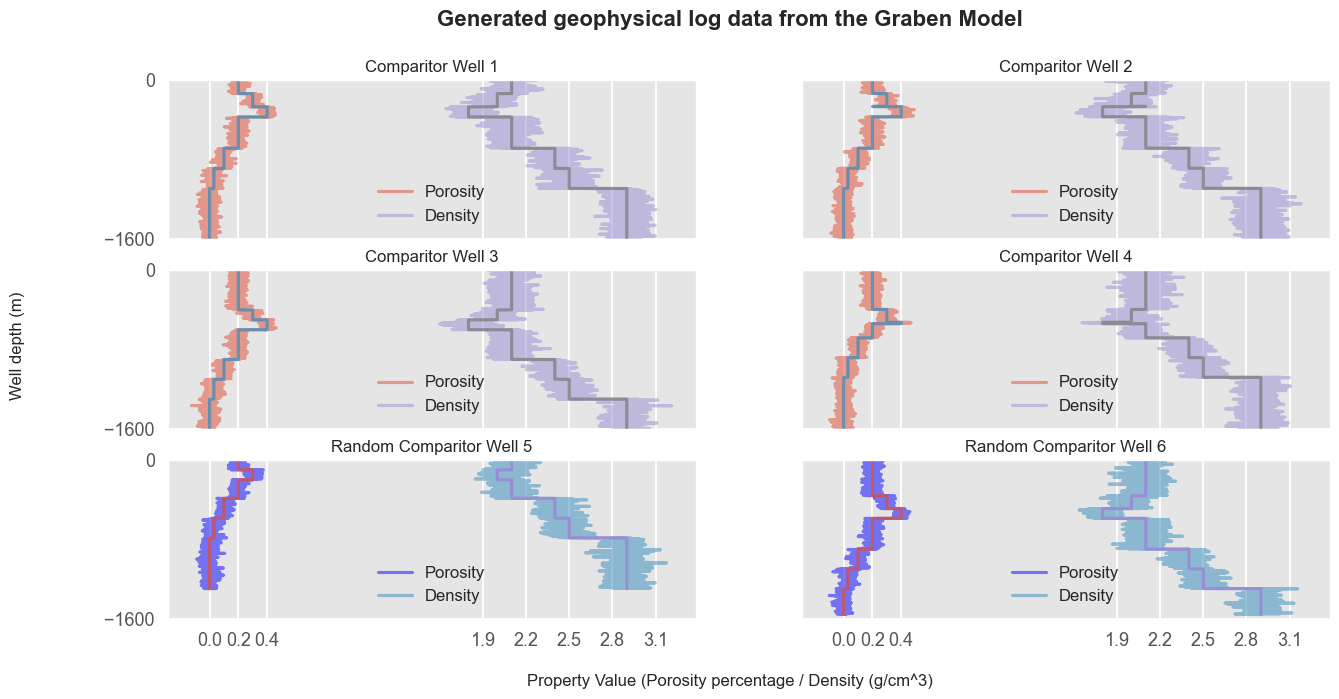

In [6]:

plt.style.use('ggplot')
fig, ax = plt.subplots(3,2, figsize=(15,7), sharex=True, sharey=True)

label_font = 12
legend_font = 12

ax[0,0].plot(welldata1[1], wellpath1[:,2]-1600, alpha=0.5,label='Porosity')
ax[0,0].plot(welldata1[0], wellpath1[:,2]-1600,alpha=0.7)
ax[0,0].plot(welldata1[3], wellpath1[:,2]-1600, alpha=0.5,label='Density')
ax[0,0].plot(welldata1[2], wellpath1[:,2]-1600, alpha=0.7)
ax[0,0].set_ylim([-1600,0])
ax[0,0].set_yticks([0, -1600])
ax[0,0].set_xticks([0,.2,.4,1.9,2.2,2.5,2.8,3.1])
ax[0,0].set_title('Comparitor Well 1', fontsize=label_font)
ax[0,0].legend(loc='lower center', fontsize=legend_font)
fig.supxlabel('Property Value (Porosity percentage / Density (g/cm^3)')
fig.supylabel('Well depth (m)')


ax[0,1].plot(welldata2[1], wellpath2[:,2]-1600, alpha=0.5,label='Porosity')
ax[0,1].plot(welldata2[0], wellpath2[:,2]-1600, alpha=0.7)
ax[0,1].plot(welldata2[3], wellpath2[:,2]-1600, alpha=0.5,label='Density')
ax[0,1].plot(welldata2[2], wellpath2[:,2]-1600, alpha=0.7)
#ax[0,1].set_ylim([0,1600])
ax[0,1].set_title('Comparitor Well 2', fontsize=label_font)
ax[0,1].legend(loc='lower center', fontsize=legend_font)


ax[1,0].plot(welldata3[1], wellpath3[:,2]-1600, alpha=0.5,label='Porosity')
ax[1,0].plot(welldata3[0], wellpath3[:,2]-1600, alpha=.7)
ax[1,0].plot(welldata3[3], wellpath3[:,2]-1600, alpha=0.5,label='Density')
ax[1,0].plot(welldata3[2], wellpath3[:,2]-1600, alpha=0.7)
#ax[1,0].set_ylim([0,1600])
ax[1,0].set_title('Comparitor Well 3', fontsize=label_font)
ax[1,0].legend(loc='lower center', fontsize=legend_font)


ax[1,1].plot(welldata4[1], wellpath4[:,2]-1600, alpha=0.5,label='Porosity')
ax[1,1].plot(welldata4[0], wellpath4[:,2]-1600, alpha=0.7)
ax[1,1].plot(welldata4[3], wellpath4[:,2]-1600, alpha=0.5,label='Density')
ax[1,1].plot(welldata4[2], wellpath4[:,2]-1600, alpha=0.7)
#ax[1,1].set_ylim([0,1600])
ax[1,1].set_title('Comparitor Well 4', fontsize=label_font)
ax[1,1].legend(loc='lower center', fontsize=legend_font)

rand1offset= 1600-len(welldataRand1[0])

ax[2,0].plot(welldataRand1[1], wellpathRand1[:,2]+rand1offset-1600, color='b', alpha=0.5,label='Porosity')
ax[2,0].plot(welldataRand1[0], wellpathRand1[:,2]+rand1offset-1600, alpha=.7)
ax[2,0].plot(welldataRand1[3], wellpathRand1[:,2]+rand1offset-1600, alpha=0.5,label='Density')
ax[2,0].plot(welldataRand1[2], wellpathRand1[:,2]+rand1offset-1600, alpha=1)
#ax[2,0].set_ylim([0,1600])
ax[2,0].set_title('Random Comparitor Well 5', fontsize=label_font)
ax[2,0].legend(loc='lower center', fontsize=legend_font)

rand2offset = 1600-len(welldataRand2[0])

ax[2,1].plot(welldataRand2[1], wellpathRand2[:,2]+rand2offset-1600, color='b', alpha=0.5,label='Porosity')
ax[2,1].plot(welldataRand2[0], wellpathRand2[:,2]+rand2offset-1600, alpha=.7)
ax[2,1].plot(welldataRand2[3], wellpathRand2[:,2]+rand2offset-1600, alpha=0.5,label='Density')
ax[2,1].plot(welldataRand2[2], wellpathRand2[:,2]+rand2offset-1600, alpha=1)
#ax[2,1].set_ylim([0,1600])
ax[2,1].set_title('Random Comparitor Well 6', fontsize=label_font)
ax[2,1].legend(loc='lower center', fontsize=legend_font)

fig.suptitle('Generated geophysical log data from the Graben Model', fontsize=16, fontweight='bold')
fig.savefig('..//..//reports//figures//graben_comparitor_wells.svg')

In [7]:
# Compiling the simulation output into pandas Dataframes
well1_df = pd.DataFrame(np.array([wellpath1[:,0], wellpath1[:,1], wellpath1[:,2], welldata1[1][::-1], welldata1[3][::-1]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])#,'CP_Prob_RHO','CP_Prob_PHI'])
well2_df = pd.DataFrame(np.array([wellpath2[:,0], wellpath2[:,1], wellpath2[:,2], welldata2[1][::-1], welldata2[3][::-1]],dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])#,'CP_Prob_RHO','CP_Prob_PHI'])
well3_df = pd.DataFrame(np.array([wellpath3[:,0], wellpath3[:,1], wellpath3[:,2], welldata3[1][::-1], welldata3[3][::-1]],dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])#,'CP_Prob_RHO','CP_Prob_PHI'])
well4_df = pd.DataFrame(np.array([wellpath4[:,0], wellpath4[:,1], wellpath4[:,2], welldata4[1][::-1], welldata4[3][::-1]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])#,'CP_Prob_RHO','CP_Prob_PHI'])
well5_df = pd.DataFrame(np.array([wellpathRand1[:,0], wellpathRand1[:,1], wellpathRand1[:,2], welldataRand1[1][::-1], welldataRand1[3][::-1]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])#,'CP_Prob_RHO','CP_Prob_PHI'])
well6_df = pd.DataFrame(np.array([wellpathRand2[:,0], wellpathRand2[:,1], wellpathRand2[:,2], welldataRand2[1][::-1], welldataRand2[3][::-1]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])#,'CP_Prob_RHO','CP_Prob_PHI'])

well1_df.head()

,X,Y,MD,PHI,RHO
0,10.0,10.0,0.0000000000,0.2304379415,1.9489307130
1,10.0,10.0,1.0006253909,0.1713477014,2.2712201225
2,10.0,10.0,2.0012507817,0.2123777763,2.1016686409
3,10.0,10.0,3.0018761726,0.1730179066,2.0523884216
4,10.0,10.0,4.0025015635,0.1782528271,2.0276577289


In [8]:
#Function to incorporate multiple data series into a change-point model 

def multi_var_CP(df, log1, log2, start, stop, label, segment_length, method, prior, engine, normal, **kwargs):

    '''
    Multivariant change-point analysis tool:

    Parameters:
    df -

    '''
    
    #Keyword Args assingment
    _prior = kwargs.get('prior')    # choices are "const", "geometric", "neg_binomial"
    _method = kwargs.get('method')  # choices are 'gauss' or 'full_cov' (although 'ifm' exits, is not yet implemented)
    _engine = kwargs.get('engine')  # choices are "numpy" or "numba"
    _normalize = kwargs.get('normal')

    #Argument Defaults
    if _method == None:
        _method = "full_cov"
    if _prior == None:
        _prior = "const"
    if _engine == None:
        _engine ="numba"
    datas = np.vstack((cp_Comp.normalize_array(df[log1][start:stop].to_numpy(),0,0),cp_Comp.normalize_array(df[log2][start:stop].to_numpy(),0,0)))
    print('finding changepoints in '+log1+' and '+log2)
    labl = label+'Multivariate'
    changepoint_prob = cp_Tools.bayes_offline_split(datas.T, segment_length=segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)
        
    log_index_array = df[log1][start:stop].index
    d = {labl : pd.Series(changepoint_prob, index=log_index_array)}
    dfcp = pd.DataFrame(data=d) 
    df = pd.concat([df, dfcp], axis=1,)

    return df

In [9]:

''' TEST CELL
_syn_grab_log = ['RHO', 'PHI']#['PHI', 'RHO']


_segment_length = 800 # the method will split the dataset into equal chunks to compute their probabilities separately, mostly for computational efficiency
_window_size = 100 # when filling missing data with the 'local_average' method, this is the parameter fed into np.convolve to impute the missing vals
_method = 'full_cov'
_prior = 'const'
_engine = 'numba'
_normalize = True

well1_multi = multi_var_CP(well1_df, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=1600, label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)
'''

" TEST CELL\n_syn_grab_log = ['RHO', 'PHI']#['PHI', 'RHO']\n\n\n_segment_length = 800 # the method will split the dataset into equal chunks to compute their probabilities separately, mostly for computational efficiency\n_window_size = 100 # when filling missing data with the 'local_average' method, this is the parameter fed into np.convolve to impute the missing vals\n_method = 'full_cov'\n_prior = 'const'\n_engine = 'numba'\n_normalize = True\n\nwell1_multi = multi_var_CP(well1_df, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=1600, label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)\n"

In [33]:


_syn_grab_log = ['RHO', 'PHI']#['PHI', 'RHO']


_segment_length = 400 # the method will split the dataset into equal chunks to compute their probabilities separately, mostly for computational efficiency
_window_size = 100 # when filling missing data with the 'local_average' method, this is the parameter fed into np.convolve to impute the missing vals
_method = 'full_cov'
_prior = 'const'
_engine = 'numba'
_normalize = True


#well1phi = np.array(((well1['PHI'].values)**2)**0.5, dtype='float64')
#type(well1phi) 
#well1_prob_phiba = cp_Tools.bayes_offline_sdt(well1phi, engine='numba')# method=_method, prior=_prior, engine=_engine)#, normal=_normalize)

well1_mono = cp_Comp.return_df_add_CP_Prob(well1_df, start=0, stop=len(well1_df), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize, method=_method)
well1 = multi_var_CP(well1_mono, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=len(well1_mono), label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)
# #cp_Comp.df_add_CP_Prob(well1, start=0, stop=len(well1), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

well2_mono = cp_Comp.return_df_add_CP_Prob(well2_df, start=0, stop=len(well2_df), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize, method=_method)
well2 = multi_var_CP(well2_mono, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=len(well2_mono), label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)

# # # #cp_Comp.df_add_CP_Prob(well2, start=0, stop=len(well2), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

well3_mono = cp_Comp.return_df_add_CP_Prob(well3_df, start=0, stop=len(well3_df), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize, method=_method)
well3 = multi_var_CP(well3_mono, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=len(well3_mono), label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)

# # #cp_Comp.df_add_CP_Prob(well3, start=0, stop=len(well3), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

well4_mono = cp_Comp.return_df_add_CP_Prob(well4_df, start=0, stop=len(well4_df), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize, method=_method) 
well4 = multi_var_CP(well4_mono, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=len(well4_mono), label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)

# # #cp_Comp.df_add_CP_Prob(well4, start=0, stop=len(well4), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)
 
well5_mono = cp_Comp.return_df_add_CP_Prob(well5_df, start=0, stop=len(well5_df), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize, method=_method)
well5 = multi_var_CP(well5_mono, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=len(well5_mono), label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)

# # # #cp_Comp.df_add_CP_Prob(well5, start=0, stop=len(well5), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

well6_mono = cp_Comp.return_df_add_CP_Prob(well6_df, start=0, stop=len(well6_df), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize, method=_method)
well6 = multi_var_CP(well6_mono, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=len(well6_mono), label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)

# #cp_Comp.df_add_CP_Prob(well6, start=0, stop=len(well6), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)


finding changepoints in RHO
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in PHI: 1600 of 1600
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in RHO and PHIf 1600
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in RHO: 1600 of 1600
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in PHI: 1600 of 1600
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in RHO and PHIf 1600
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in RHO: 1600 of 1600
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in PHI: 1600 of 1600
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in RHO and PHIf 1600
method- full_cov, prior- const, engine- numba
Segmenting into 400
/nfinding changepoints in 

In [34]:
#Checking output of Probability curves
well1.head()

#well1['CP_Prob_RHO', 'CP_Prob_PHI', 'CP_Prob_Multivariate'].plot()

,X,Y,MD,PHI,RHO,CP_Prob_RHO,CP_Prob_PHI,CP_Prob_Multivariate
0,10.0,10.0,0.0000000000,0.2304379415,1.9489307130,0.0000000000,0.0000000000,0.0000000000
1,10.0,10.0,1.0006253909,0.1713477014,2.2712201225,0.0001599622,0.0009364779,0.0000783787
2,10.0,10.0,2.0012507817,0.2123777763,2.1016686409,0.0001955129,0.0004407285,0.0003521584
3,10.0,10.0,3.0018761726,0.1730179066,2.0523884216,0.0001764520,0.0006337115,0.0001644642
4,10.0,10.0,4.0025015635,0.1782528271,2.0276577289,0.0001580534,0.0005614347,0.0000814940


In [9]:
'''Un-Split Change-point modeling, this shows what one might use for a one-off analysis, two single-variate
and a combined multivariate model. 

This example uses input from the well 1 data simulated above 
'''
#setting up the offline bayesian change-point class with model hyperparameters
detOffBay = cp_Tools.sdt_cp.BayesOffline('const', 'full_cov', engine='numba')#, prior_params={'p' : 0.00004})

#Normalizing data series 1 and 2 and stacking them into a matrix to feed into the analysis
data1 = cp_Comp.normalize_array(well1_df['RHO'][::-1].values,0,0)
data2 = cp_Comp.normalize_array(well1_df['PHI'][::-1].values,0,0)
datas = np.vstack((data1,data2))

# Full output of the offline Bayesian model for each analysis
prob_comb, q_comb, p_comb, pcp_comb = detOffBay.find_changepoints(datas.T, full_output=True)
prob_phi, q_phi, phi_phi, pcp_phi = detOffBay.find_changepoints(data2.T, full_output=True)
prob_rho, q_rho, phi_rho, pcp_rho = detOffBay.find_changepoints(data1.T, full_output=True)

Text(0.5, 1.0, 'log likelihood of i-th CP at n-th datapoint')

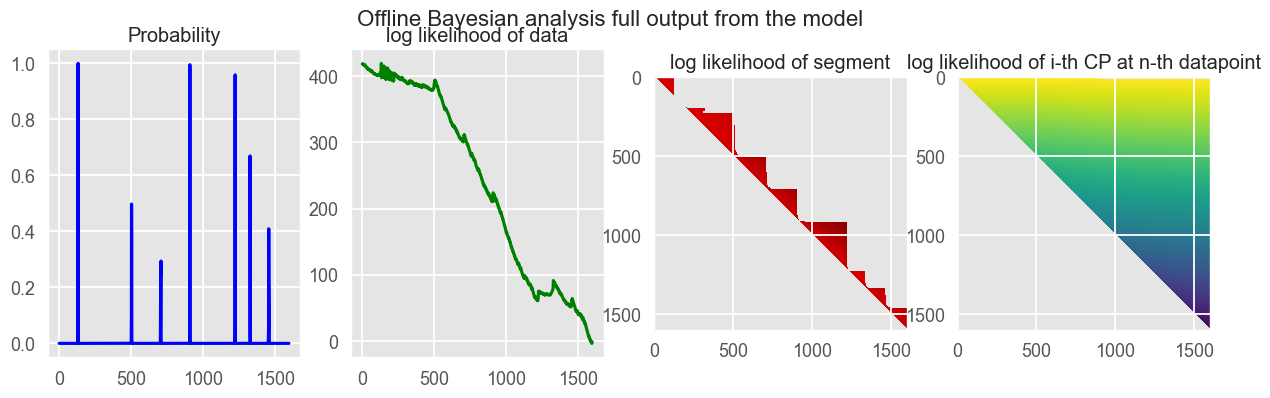

In [30]:
#Plot of the Multivariate Full output

fig, ax = plt.subplots(1,4, figsize=(15,4))
fig.suptitle('Offline Bayesian analysis full output from the model', fontsize=16)
ax[0].plot(prob_comb, color='b')
ax[0].set_title('Probability')
ax[1].plot(q_comb, color='g')
ax[1].set_title('log likelihood of data')
ax[2].imshow(p_comb, cmap='jet')
ax[2].set_title('log likelihood of segment')
ax[3].imshow(pcp_comb, cmap='viridis')
ax[3].set_title('log likelihood of i-th CP at n-th datapoint')

In [1]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1,3, figsize=(18,5), layout='tight')

#ax2  = ax.twinx()
ax[0].plot(datas[0,:], label='RHO data', alpha=0.5, linewidth=1)
ax[0].plot(prob_comb, label='change-point probability', linewidth=1)
ax[0].plot(datas[1,:], label='PHI data',  alpha=0.5, linewidth=1)

ax[0].set_title('Combined (Multivariate)', size=12)
ax[1].plot(datas[0,:], alpha=.5, label = 'Normalized RHO Measurement', linewidth=1)
ax[1].plot(prob_rho, label='change-point probability', linewidth=1)
ax[1].set_title('Density (RHO)', size=12)

ax[2].plot(datas[1,:], alpha=0, linewidth=1)
ax[2].plot(prob_phi, label='change-point probability', linewidth=1)
ax[2].plot(datas[1,:], alpha=0.5, label = 'Normalized PHI Measurement', linewidth=1)
ax[2].set_title('Porosity (PHI)', size=12)
#ax[0].plot(prob_comb, 'change-point probability')
##ax2.plot(welldata1[2], label='True Value')
#ax.plot(cp_Comp.normalize_array(welldata1[2],0,0)*0.9)
for i in range(3):
    ax[i].legend(loc='upper center',fontsize=14)
    ax[i].set_ylim(-0.05,1.3)
    ax[i].set_yticks([0,.25,.5,.75,1])
    #ax[i].set_xticks([505,705,910,1224,1326,1462])
    ax[i].set_xticks([1095,893,690,376,270,137])
    ax[i].tick_params(labelsize=9)
fig.suptitle('Offline Bayesian Change-Point analysis - Well 1 -', fontweight='bold', fontsize=16)
#x.legend()
ax[1].set_xlabel('Well Depth (m)   (ticks indicate true change-points)', size=14)
ax[0].set_ylabel('Probability (only true for blue curve)', size=14)
#fig.savefig('..//..//reports//figures//well1_cp_analysis.svg')
#plt.plot(welldata1[3]

NameError: name 'plt' is not defined

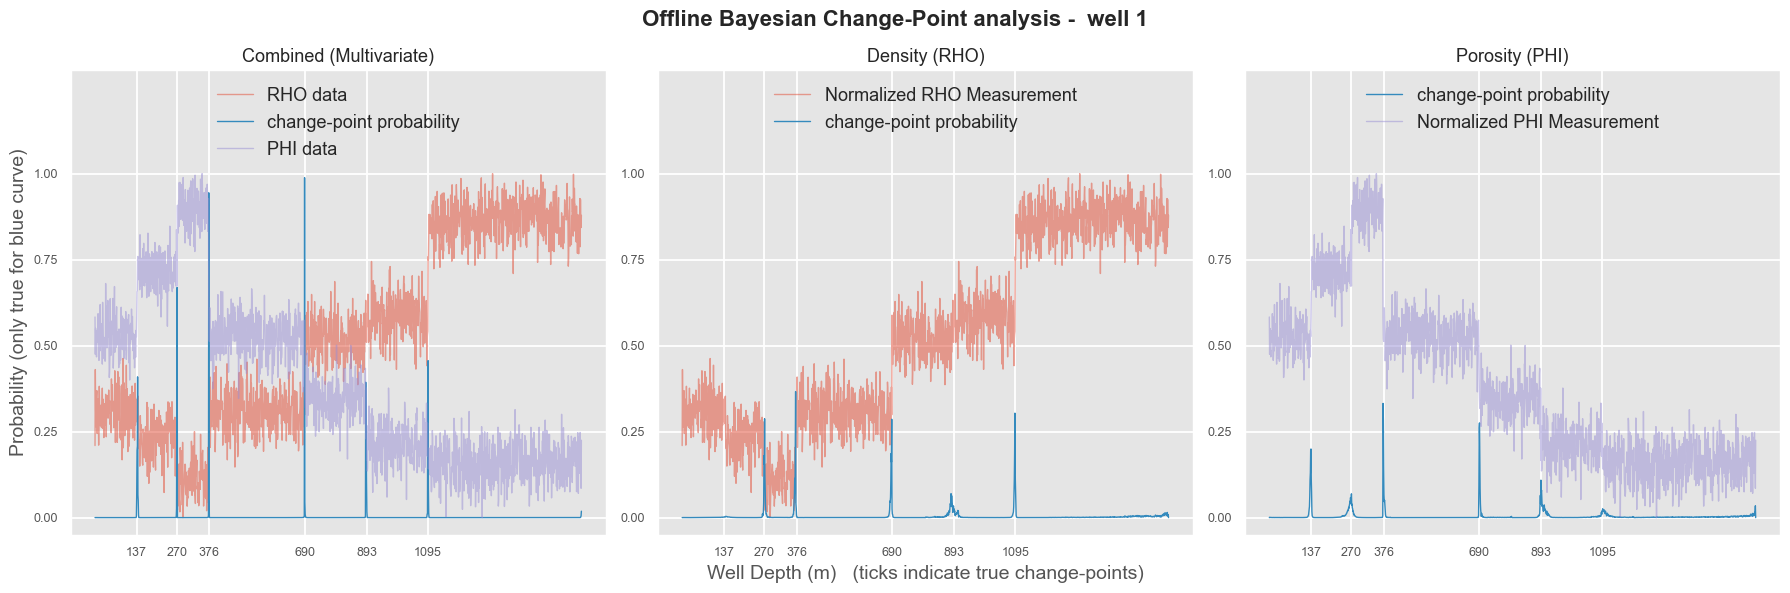

In [35]:
# Plotting well 1 results from change-point model 


well = well1
wellname = ' well 1'
datas_ = np.vstack((cp_Comp.normalize_array(well['RHO'],0,0),cp_Comp.normalize_array(well['PHI'],0,0)))

prob_comb_ = well['CP_Prob_Multivariate']
prob_phi_ = well['CP_Prob_PHI']
prob_rho_ = well['CP_Prob_RHO']

plt.style.use('ggplot')
fig, ax = plt.subplots(1,3, figsize=(18,6), layout='tight')

#ax2  = ax.twinx()
ax[0].plot(datas_[0,:], label='RHO data', alpha=0.5, linewidth=1)
ax[0].plot(prob_comb_, label='change-point probability', linewidth=1)
ax[0].plot(datas_[1,:], label='PHI data',  alpha=0.5, linewidth=1)

ax[0].set_title('Combined (Multivariate)', size=13)
ax[1].plot(datas_[0,:], alpha=.5, label = 'Normalized RHO Measurement', linewidth=1)
ax[1].plot(prob_rho_, label='change-point probability', linewidth=1)
ax[1].set_title('Density (RHO)', size=13)

ax[2].plot(datas_[1,:], alpha=0, linewidth=1)
ax[2].plot(prob_phi_, label='change-point probability', linewidth=1)
ax[2].plot(datas_[1,:], alpha=0.5, label = 'Normalized PHI Measurement', linewidth=1)
ax[2].set_title('Porosity (PHI)', size=13)
#ax[0].plot(prob_comb, 'change-point probability')
##ax2.plot(welldata1[2], label='True Value')
#ax.plot(cp_Comp.normalize_array(welldata1[2],0,0)*0.9)
for i in range(3):
    ax[i].legend(loc='upper center',fontsize=13)
    ax[i].set_ylim(-0.05,1.3)
    ax[i].set_yticks([0,.25,.5,.75,1])
    #ax[i].set_xticks([505,705,910,1224,1326,1462])
    ax[i].set_xticks([1095,893,690,376,270,137])
    ax[i].tick_params(labelsize=9)
fig.suptitle('Offline Bayesian Change-Point analysis - '+ wellname, fontweight='bold', fontsize=16)
#x.legend()
ax[1].set_xlabel('Well Depth (m)   (ticks indicate true change-points)', size=14)
ax[0].set_ylabel('Probability (only true for blue curve)', size=14)
fig.savefig('..//..//reports//figures//well1_cp_analysis.svg')

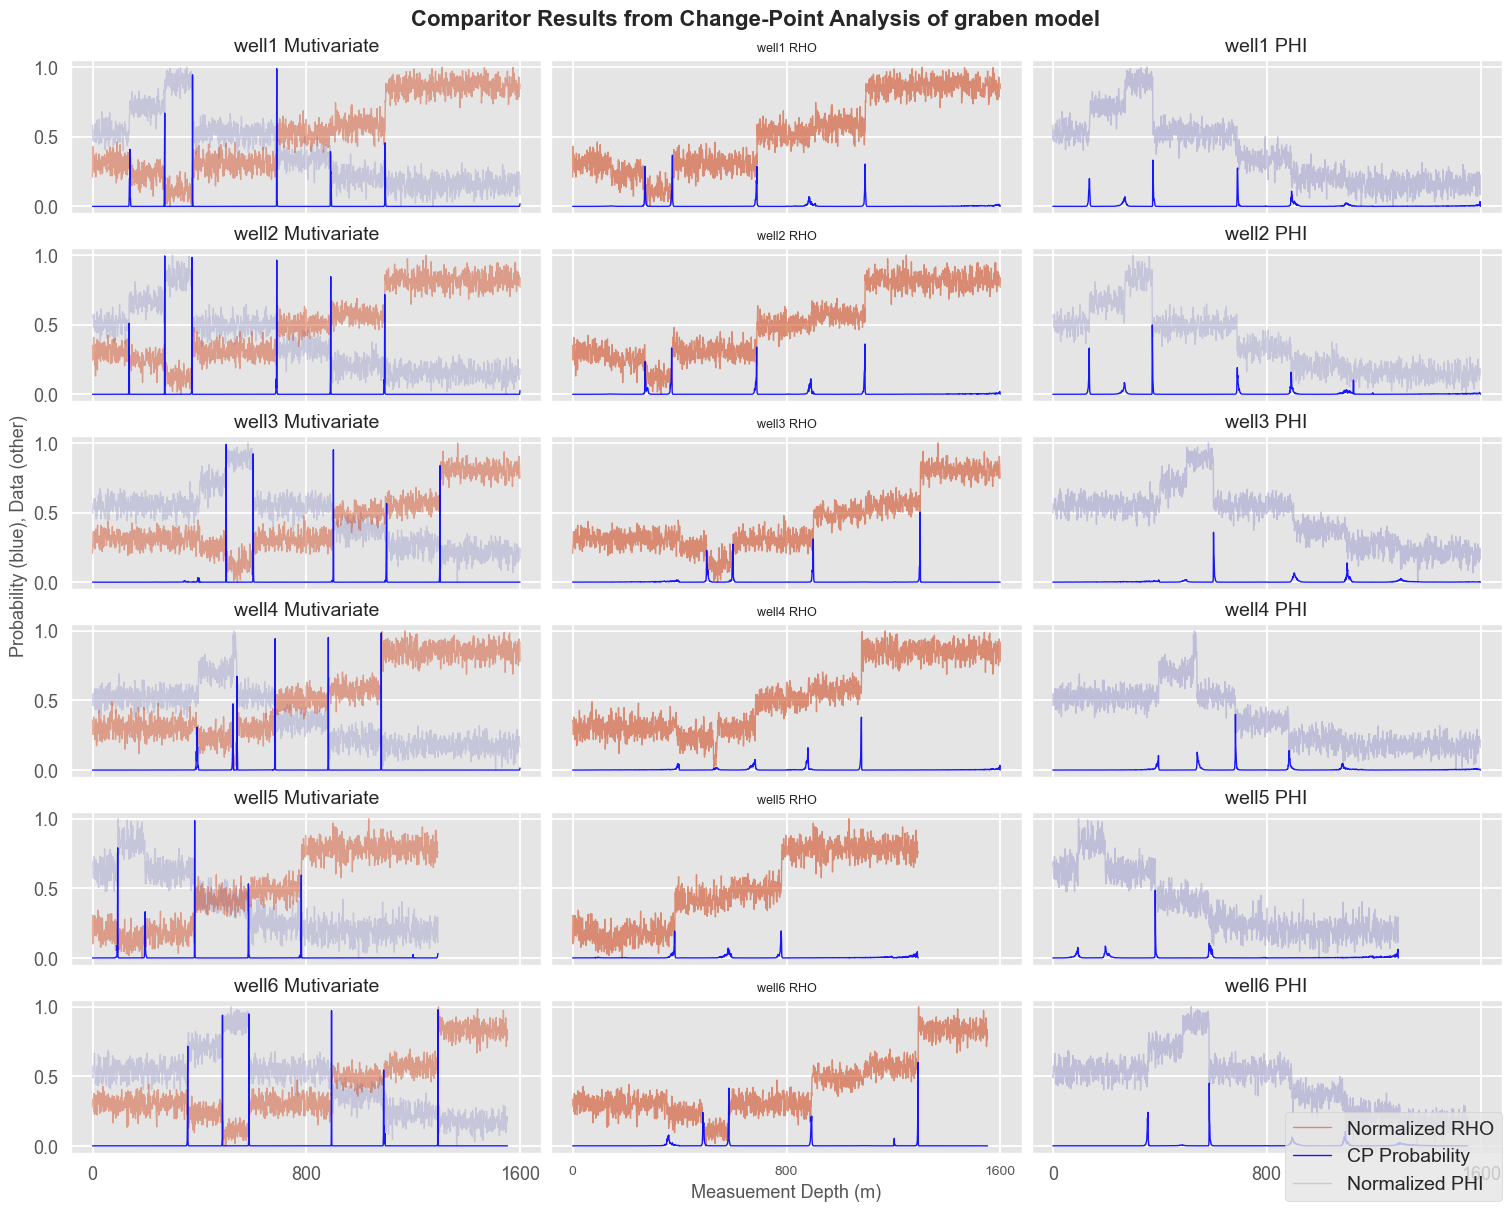

In [36]:
# BUILD NORMALIZED DATA FOR PLOTTING PROBABILITY RESULTS FOR THE COMPARITORS


plt.style.use('ggplot')
fig, ax = plt.subplots(6,3, sharex=True, sharey=True,figsize=(15,12), layout='constrained')

_log_list_ = ['RHO','PHI','RHO']

_prob_list_ = ['CP_Prob_RHO','CP_Prob_PHI','CP_Prob_Multivariate']

_wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6']
_well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6}
ax[0,0].set_xticks([0,800,1600])
label_size = 10
#plt.rcParams['xtick.labelsize'] = label_size
ax[5,1].tick_params(labelsize=10)
ax[5,1].set_xlabel('Measuement Depth (m)', size=13)
ax[2,0].set_ylabel('Probability (blue), Data (other)         ', size=13)
#tick_params(labelsize=9)
for well in _wellnames_:
    for _log_choice in _log_list_:

        globals()[well+'_'+_log_choice+'_norm'] = cp_Comp.normalize_array(_well_df_[well][_log_choice],0,0)
       
for i, well in zip(range(len(_wellnames_)), _wellnames_):
    for j, prob_ in zip(range(len(_log_list_)), _prob_list_):
        #ax[i,j].legend(loc='center right',fontsize=7)
        if j==0:
            
            ax[i,1].set_title(well+' '+_log_list_[j], fontsize=9)
            if i == 0:
                ax[i,1].plot(globals()[well+'_'+_log_list_[j]+'_norm'], linewidth=1, label='Normalized RHO', alpha=0.5, color="#CC3300")
                ax[i,1].plot(_well_df_[well][prob_], linewidth=1, label='CP Probability', color='b', alpha=0.9)
            else:
                ax[i,1].plot(globals()[well+'_'+_log_list_[j]+'_norm'], linewidth=1, alpha=0.5,color="#CC3300")

                ax[i,1].plot(_well_df_[well][prob_], linewidth=1, color='b', alpha=0.9)
        elif j==1:
            if i == 1:
                ax[i,2].plot(globals()[well+'_'+_log_list_[j]+'_norm'], linewidth=1, label='Normalized PHI', alpha=0.4,color="#9999CC")
            else:
                ax[i,2].plot(globals()[well+'_'+_log_list_[j]+'_norm'], linewidth=1, alpha=0.5,color="#9999CC")
            ax[i,2].set_title(well+' '+_log_list_[j], fontsize=14)
            ax[i,2].plot(_well_df_[well][prob_], linewidth=1, color='b', alpha=0.9)
        elif j == 2:
            ax[i,0].plot(globals()[well+'_PHI_norm'], linewidth=1, alpha=0.4, color='#9999CC')
            ax[i,0].plot(globals()[well+'_RHO_norm'], linewidth=1, alpha=0.4, color="#CC3300")
            ax[i,0].set_title(well+' Mutivariate', fontsize=14)
            ax[i,0].plot(_well_df_[well][prob_], linewidth=1, color='b', alpha=0.9)
fig.legend(loc='lower right',fontsize=14, frameon=True)
fig.suptitle('Comparitor Results from Change-Point Analysis of graben model', fontweight='bold', fontsize=16)
#fig.savefig('..//..//reports//figures//syn_graben_cp_comparitors.svg')


##### This seciton now creates the data for the Comparitee well. Simulation, change-point modeling, and data structure






In [38]:
''' Now that the compriTORs are build from the synthetic model we drill a well in a random spot on the model
and see how this CompariTEE can have property changes predited by what we know from the wells before'''

np.random.seed(seed=1234) # static when this needs repeating

TEEdepth = 1400 #This sets the depth of the comparitee well **** must change the depth in _logname_extents_max_ dict in the folloeing cell to match***


'''This runs a synthetic well from the well drilling class above:

in an investigation, the CompariTEE well location could also be 'drilled' in the best known model to be used as an input for 
a CompariTOR, as this model will include some value based on expert interpretations and a realistic interpolation of current
 observations'''
xx =  randI(0,2000)
yy =  randI(0,2000)
print(xx,yy)

OBSERwellpath, OBSERwelldata = well_from_graben_model(xx, yy, TEEdepth, 0, TEEdepth , .08, .03).return_well()

well7_df = pd.DataFrame(np.array([OBSERwellpath[:,0], OBSERwellpath[:,1], OBSERwellpath[:,2], OBSERwelldata[1], OBSERwelldata[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])#, 'CP_Prob_PHI', 'CP_Prob_RHO'])

well7 = cp_Comp.return_df_add_CP_Prob(well7_df, start=0, stop=len(well7_df), log_dict=_syn_grab_log, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True, method=_method)
well7 = multi_var_CP(well7, _syn_grab_log[0], _syn_grab_log[1], start=0, stop=len(well7_df), label='CP_Prob_', segment_length=_segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)

815 723
Active grids: ['regular']


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\gempy\core\data_modules\orientations.py:85: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Active grids: ['regular' 'sections']
[[815.0 723.0 0.0]
 [815.0 723.0 1.0007147962830594]
 [815.0 723.0 2.0014295925661187]
 [815.0 723.0 3.002144388849178]]
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                             values
range              3249.6153618544
$C_o$            251428.5714285714
drift equations       [3, 3, 3, 3]
Active grids: ['custom']
([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [40]:
#Checking the depths of the wells

len(well1), len(well2), len(well3), len(well4),len(well5), len(well6), len(well7)

#well7['CP_Prob_RHO'].plot() # plot the comparitee well density probability

(1600, 1600, 1600, 1600, 1293, 1553, 1400)

In [41]:
'''This cell builds the segment trends, calculating: mean, median, linear regression slope and relative intercept'''

# _log_ = 'GR'
# _prob_ = 'CP_Prob_GR'

_log_list_ = ['PHI','RHO']
_prob_list_ = ['CP_Prob_RHO','CP_Prob_PHI']

_wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6', 'well7']
_well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6, 'well7': well7}

_logname_extent_min = {'well1': 0 ,'well2' : 0, 'well3' : 0 , 'well4': 0 , 'well5' : 0 , 'well6': 0, 'well7' :0 }
_logname_extent_max = {'well1': 1600 ,'well2' : 1600, 'well3' : 1600 , 'well4': 1600 , 'well5' : 1075 , 'well6': 1497, 'well7' : len(well7) }

peak_height= 0.04 #Probability threshold to qualify as a distinct changepoint

for well in _wellnames_:
    for _log_choice, _prob_choice in zip(_log_list_, _prob_list_):

        globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

        print(well+ '_'+ _log_choice + ' complete')

for well in _wellnames_:
    
    globals()[well+'_'+'Multivariate'+'_RHOstats'] = cp_Comp.changepoint_stat(_well_df_[well]['RHO'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well]['CP_Prob_Multivariate'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)
    globals()[well+'_'+'Multivariate'+'_PHIstats'] = cp_Comp.changepoint_stat(_well_df_[well]['PHI'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well]['CP_Prob_Multivariate'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)
    globals()[well+'_'+'Multivariate'+'_CPstats'] = np.concatenate((globals()[well+'_'+'Multivariate'+'_RHOstats'],globals()[well+'_'+'Multivariate'+'_PHIstats']), axis=1)                                                

11 Change points: [ 269  271  370  373  683  687  689  881  884  886 1094]
well1_PHI complete
10 Change points: [137 265 267 270 374 379 691 891 893 895]
well1_RHO complete
11 Change points: [ 271  276  278  280  370  684  688  885  887  891 1093]
well2_PHI complete
9 Change points: [ 136  267  372  690  692  888  891  897 1124]
well2_RHO complete
6 Change points: [ 501  505  599  896  900 1300]
well3_PHI complete
8 Change points: [ 601  901  904 1099 1101 1103 1106 1110]
well3_RHO complete
10 Change points: [ 392  394  397  676  678  682  874  877  880 1080]
well4_PHI complete
12 Change points: [ 388  391  393  395  540  545  683  884  886 1081 1084 1086]
well4_RHO complete
5 Change points: [375 381 582 586 780]
well5_PHI complete
9 Change points: [ 89  93 196 383 585 587 590 594 596]
well5_RHO complete
10 Change points: [ 352  357  359  487  490  584  892  894 1203 1292]
well6_PHI complete
8 Change points: [ 354  356  585  895  898 1089 1092 1094]
well6_RHO complete
5 Change points: 

In [43]:
'''
a = np.where(well7_PHI_CPstats[:,0] < 300 )
np.where(well7_PHI_CPstats[:,0] < 300 )[0][-1]
'''


'\na = np.where(well7_PHI_CPstats[:,0] < 300 )\nnp.where(well7_PHI_CPstats[:,0] < 300 )[0][-1]\n'

In [44]:
''' This instantiates the matching algorithm, and stores these Comparitee/Comparitor matches for each well pair'''
# _log_ = 'GR'
# _prob_ = 'CP_Prob_GR'

#List of comparing logs
_log_list_ = ['RHO','PHI','Multivariate']
_prob_list_ = ['CP_Prob_RHO','CP_Prob_PHI', 'CP_Prob_Multivariate']

#wells to compare
_wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6', 'well7']
_well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6, 'well7': well7}

#Change this variable to set the probability threshold that qualify as a distinct changepoint
peak_height= 0.06

operator = 'cosine'
thresh = 0.997


comparitee = 'well7'

Tor = []

for well in _wellnames_:
    for _prob_, _log_ in zip(_prob_list_,_log_list_):
        print(_prob_,_log_)
        Tee = globals()[comparitee+'_'+_log_+'_CPstats'] 
        Tor = globals()[well+'_'+_log_+'_CPstats']
        #globals() function creates a dynamically named global variable from the string segments 
        globals()[well+'_'+comparitee+'_'+_log_+'_prob'] = cp_Comp.prob_cpCorr(Tee, Tor, operator=operator, thresh=thresh, df=_well_df_[well], log=_prob_)
      
    #f1_11A_GR_prob = prob_cpCorr(f11A_GRmu, f1_GRmu, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_GR')

CP_Prob_RHO RHO
*MATCH at CP_Prob_RHO Tor depth 137 to Tee depth 484 with cosine value 0.9972822257397116
adding Tor probabilites to Tee cumulative matix, from 484
*MATCH at CP_Prob_RHO Tor depth 270 to Tee depth 484 with cosine value 0.9989809689418964
adding Tor probabilites to Tee cumulative matix, from 484
*MATCH at CP_Prob_RHO Tor depth 137 to Tee depth 680 with cosine value 0.9997716520249568
adding Tor probabilites to Tee cumulative matix, from 680
*MATCH at CP_Prob_RHO Tor depth 265 to Tee depth 680 with cosine value 0.9997000183318797
adding Tor probabilites to Tee cumulative matix, from 680
*MATCH at CP_Prob_RHO Tor depth 267 to Tee depth 680 with cosine value 0.9993714010148733
adding Tor probabilites to Tee cumulative matix, from 680
*MATCH at CP_Prob_RHO Tor depth 270 to Tee depth 680 with cosine value 0.9985693210059374
adding Tor probabilites to Tee cumulative matix, from 680
*MATCH at CP_Prob_RHO Tor depth 379 to Tee depth 680 with cosine value 0.9993336425482868
adding

In [46]:
well7_probmatrix = cp_Comp.combine_vectors_to_matrix_(well1_well7_RHO_prob,
                                                         well2_well7_RHO_prob,
                                                         well3_well7_RHO_prob, 
                                                         well4_well7_RHO_prob,
                                                         well5_well7_RHO_prob, 
                                                         well6_well7_RHO_prob,
                                                         well1_well7_PHI_prob,
                                                         well2_well7_PHI_prob,
                                                         well3_well7_PHI_prob, 
                                                         well4_well7_PHI_prob,
                                                         well5_well7_PHI_prob, 
                                                         well6_well7_PHI_prob)

well7_probmatrixMultivariate = cp_Comp.combine_vectors_to_matrix_(well1_well7_Multivariate_prob,
                                                         well2_well7_Multivariate_prob,
                                                         well3_well7_Multivariate_prob, 
                                                         well4_well7_Multivariate_prob,
                                                         well5_well7_Multivariate_prob, 
                                                         well6_well7_Multivariate_prob)

well7_probmatrixPHI = cp_Comp.combine_vectors_to_matrix_(well1_well7_PHI_prob,
                                                         well2_well7_PHI_prob,
                                                         well3_well7_PHI_prob, 
                                                         well4_well7_PHI_prob,
                                                         well5_well7_PHI_prob, 
                                                         well6_well7_PHI_prob)


well7_probmatrixRHO = cp_Comp.combine_vectors_to_matrix_(well1_well7_RHO_prob,
                                                         well2_well7_RHO_prob,
                                                         well3_well7_RHO_prob, 
                                                         well4_well7_RHO_prob,
                                                         well5_well7_RHO_prob, 
                                                         well6_well7_RHO_prob)

well7_all_prob = cp_Comp.combine_vectors_to_matrix_(well7['CP_Prob_PHI'].values, well7['CP_Prob_RHO'].values)

peaks = cp_Tools.find_prob_peaks(np.sum(well7_all_prob, axis=1), height=0.1)

rows  1600 columns 12
rows  1600 columns 6
rows  1600 columns 6
rows  1600 columns 6
rows  1400 columns 2


##### Setting a variable with the true chanvge points from Well 7 

In [47]:
'''This sets the true peak values for the Comparitee well, sadly this is not automated''' 

#bottom = 1600 
true_peaks = [288, 483, 687, 987, 1077, 1199, 1600]
#true_peaks = true_peaks.append(bottom)
#true_peaks

[288, 483, 687, 987, 1077, 1199, 1600]

##### This cell combines much of the analysis from above to simulate a hypothetical drilling program. Adding an increasing portion of the Comparitee Well, Well 7, and updating a forecast for property changes ahead of the drill bit.

###### The syn_graben_anim function may be called for a specific time step, or run in a 100 frame animation of the entire drilling processs.

1400
1400
7 Change points: [ 269  271  370  373  687  689 1094]
well1_RHO complete
5 Change points: [137 374 691 893 895]
well1_PHI complete
8 Change points: [ 271  370  684  688  885  887  891 1093]
well2_RHO complete
7 Change points: [ 136  267  372  690  692  891 1124]
well2_PHI complete
6 Change points: [ 501  505  599  896  900 1300]
well3_RHO complete
3 Change points: [ 601 1101 1103]
well3_PHI complete
4 Change points: [ 682  877  880 1080]
well4_RHO complete
5 Change points: [395 540 683 884 886]
well4_PHI complete
3 Change points: [381 582 780]
well5_RHO complete
6 Change points: [ 93 196 383 585 587 590]
well5_PHI complete
8 Change points: [ 357  359  487  490  584  892  894 1292]
well6_RHO complete
4 Change points: [ 354  356  585 1094]
well6_PHI complete
5 Change points: [ 288  687  988 1075 1079]
well7_RHO complete
5 Change points: [484 680 682 685 987]
well7_PHI complete
7 Change points: [ 140  270  374  689  890  892 1095]
7 Change points: [ 140  270  374  689  890  892 

(<Figure size 1500x900 with 1 Axes>,)

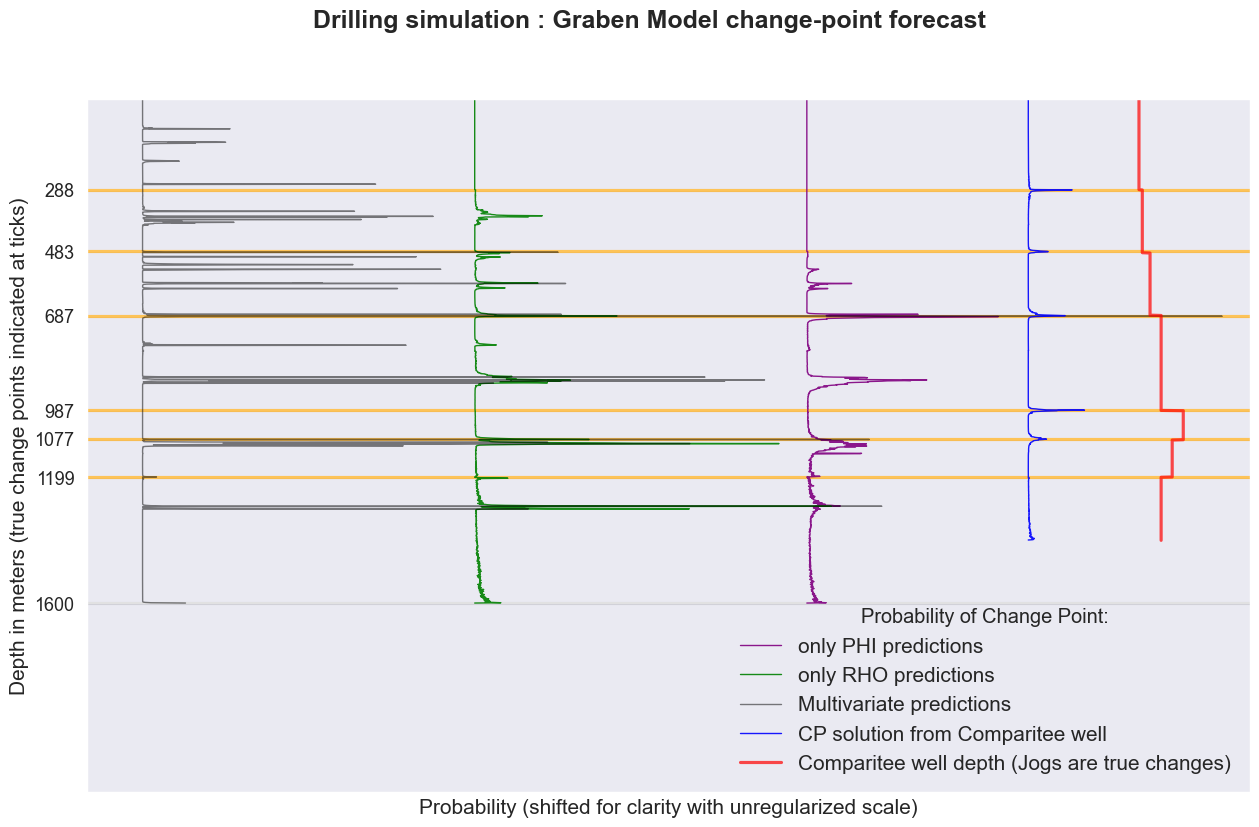

In [48]:
import matplotlib.animation as anim
import seaborn as sns
#plt.style.use('ggplot')

#### SETTING PLOTTING GLOBALS ####

sns.set_style('darkgrid')
fig, ax = plt.subplots(1, figsize=(15,9))
ax.set_yticks(true_peaks)
well5length = len(well5) # this might change 
well6length = len(well6) # this might change too




def syn_graben_anim(i):

######## ITERABLES  ########

    idx = np.linspace(100,1400,101, dtype=int)

    print(idx[i])
    
    
#########  SOURCE VARS ##########
    depth=idx[i]

    _wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6', 'well7']
    _well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6, 'well7': well7}

    _logname_extent_min = {'well1': 0 ,'well2' : 0, 'well3' : 0 , 'well4': 0 , 'well5' : 0 , 'well6': 0, 'well7' :0 }
    _logname_extent_max = {'well1': 1600 ,'well2' : 1600, 'well3' : 1600 , 'well4': 1600 , 'well5' : well5length , 'well6': well6length, 'well7' : depth }

    print(_logname_extent_max['well7'])

    peak_height= 0.07 #Probability threshold to qualify as a distinct changepoint

########   SEGMENT TREND STATISITCS  #########

    _log_list_ = ['RHO','PHI']
    _prob_list_ = ['CP_Prob_RHO','CP_Prob_PHI']
    
    for well in _wellnames_:
        for _log_choice, _prob_choice in zip(_log_list_, _prob_list_):

            globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                        _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

            print(well+ '_'+ _log_choice + ' complete')
    
    for well in _wellnames_:
    
        globals()[well+'_'+'Multivariate'+'_RHOstats'] = cp_Comp.changepoint_stat(_well_df_[well]['RHO'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well]['CP_Prob_Multivariate'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)
        globals()[well+'_'+'Multivariate'+'_PHIstats'] = cp_Comp.changepoint_stat(_well_df_[well]['PHI'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well]['CP_Prob_Multivariate'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)
        globals()[well+'_'+'Multivariate'+'_CPstats'] = np.concatenate((globals()[well+'_'+'Multivariate'+'_RHOstats'],globals()[well+'_'+'Multivariate'+'_PHIstats']), axis=1) 



###### COMPARISON METRICS #######

    operator = 'euclidean'  # GEOMETRIC COMPARITOR (could use eclidean, sector... see cp_Comp.prob_cpCorr docstring)

    thresh = 0.1  # THIS IS THE COSINE THRESHOLD FOR A MATCH (perfect match is 1.0) (euclidean match is 0, thresh = 0.1)

    comparitee = 'well7'  #CHANGE THIS TO CHANGE COMPARITEE 

    Tor = [] #BUILD EMPTY COMPARITOR LIST

########## COMPARITOR ALGORITHM #########

    _log_list_ = ['RHO','PHI','Multivariate']
    _prob_list_ = ['CP_Prob_RHO','CP_Prob_PHI', 'CP_Prob_Multivariate']
    
    for well in _wellnames_:
        for _prob_, _log_ in zip(_prob_list_,_log_list_):
            print(_prob_,_log_)
            Tee = globals()[comparitee+'_'+_log_+'_CPstats']
            Tor = globals()[well+'_'+_log_+'_CPstats']
            
            #globals()[well+'_'+comparitee+'_'+_log_+'_prob_']= cp_Comp.prob_cpCorr(Tee[:depth], Tor, operator=operator, thresh=thresh, df=_well_df_[well], log=_prob_)
            
            globals()[well+'_'+comparitee+'_'+_log_+'_prob_']= cp_Comp.prob_cpCorr(Tee[:np.where(Tee[:,0] < depth )[0][-1]], Tor, operator=operator, thresh=thresh, df=_well_df_[well], log=_prob_)
    

    #### COMBINING PROBABILITY FORECASTS INTO A SINGLE MATRIX #####
    
    well7_probmatrix = cp_Comp.combine_vectors_to_matrix_(well1_well7_RHO_prob_,
                                                         well2_well7_RHO_prob_,
                                                         well3_well7_RHO_prob_, 
                                                         well4_well7_RHO_prob_,
                                                         well5_well7_RHO_prob_, 
                                                         well6_well7_RHO_prob_,
                                                         well1_well7_PHI_prob_,
                                                         well2_well7_PHI_prob_,
                                                         well3_well7_PHI_prob_, 
                                                         well4_well7_PHI_prob_,
                                                         well5_well7_PHI_prob_, 
                                                         well6_well7_PHI_prob_)

    well7_probmatrixMultivariate = cp_Comp.combine_vectors_to_matrix_(well1_well7_Multivariate_prob_,
                                                         well2_well7_Multivariate_prob_,
                                                         well3_well7_Multivariate_prob_, 
                                                         well4_well7_Multivariate_prob_,
                                                         well5_well7_Multivariate_prob_, 
                                                         well6_well7_Multivariate_prob_)

    well7_probmatrixPHI = cp_Comp.combine_vectors_to_matrix_(well1_well7_PHI_prob_,
                                                         well2_well7_PHI_prob_,
                                                         well3_well7_PHI_prob_, 
                                                         well4_well7_PHI_prob_,
                                                         well5_well7_PHI_prob_, 
                                                         well6_well7_PHI_prob_)


    well7_probmatrixRHO = cp_Comp.combine_vectors_to_matrix_(well1_well7_RHO_prob_,
                                                         well2_well7_RHO_prob_,
                                                         well3_well7_RHO_prob_, 
                                                         well4_well7_RHO_prob_,
                                                         well5_well7_RHO_prob_, 
                                                         well6_well7_RHO_prob_)



    well7_all_prob = cp_Comp.combine_vectors_to_matrix_(well7['CP_Prob_PHI'][:depth].values, well7['CP_Prob_RHO'][:depth].values)
    


    ##### THIS IS THE PLOTTING SECTION ######


    ax.clear()
   
    #ax.spines['bottom'].set_visible(False)
    
    ax.set_xticklabels([])
   
    ax.set_xticks([])
    
    #ax.axes.get_xaxis().set_visible(False)

    ax.set_xlabel('Probability (shifted for clarity with unregularized scale)', size=15)
    ax.set_ylabel('Depth in meters (true change points indicated at ticks)', size= 15)
    
    
    ax.set_ylim(2200)
    ax.set_xlim([-.5,10.])
    ax.set_yticks(true_peaks)
    
    ax.axhline(1600, color='k', alpha=.1)
    
    for i in true_peaks:
        if i == 1600:
            ax.axhline(i, alpha=0.005, color='k')
        else:
            ax.axhline(i, alpha=0.65, color='orange')
       

    #ax.plot(np.sum(well7_probmatrix, axis=1)/len(well7_probmatrix[0]), np.arange(len(well7_probmatrix)), linewidth=1, alpha=.9, label='Combined prediction' )
    ax.plot((np.sum(well7_probmatrixPHI, axis=1)/len(well7_probmatrixPHI[0]))+6, np.arange(len(well7_probmatrixPHI)), linewidth=1, alpha=.9, label = 'only PHI predictions', color='purple' )
    ax.plot((np.sum(well7_probmatrixRHO, axis=1)/len(well7_probmatrixRHO[0]))+3, np.arange(len(well7_probmatrixRHO)), linewidth=1, alpha=.9, label = 'only RHO predictions', color='g' )
    ax.plot((np.sum(well7_probmatrixMultivariate, axis=1)/len(well7_probmatrixMultivariate[0])), np.arange(len(well7_probmatrixMultivariate)), linewidth=1, alpha=.5, label = 'Multivariate predictions', color='k' )
    #ax.plot(OBSERwelldata[0][:depth], OBSERwellpath[:depth,2], alpha=0.6)

    ax.plot(np.sum(well7_all_prob, axis=1)+8, np.arange(len(well7_all_prob)), color='b', linewidth=1, alpha=0.9, label='CP solution from Comparitee well')
    ax.plot(9+np.array(OBSERwelldata[0][:depth]), OBSERwellpath[:depth,2], alpha=0.7, color='r', label='Comparitee well depth (Jogs are true changes)')

    fig.suptitle('Drilling simulation : Graben Model change-point forecast', fontsize=18, fontweight='bold')

    plt.legend(loc='lower right', frameon=False, title='Probability of Change Point:', prop={'size': 15}, title_fontsize='x-large')

    return fig, 


##### SINGLE FORECAST AT TIME STEP passed as an argument #####


syn_graben_anim(100)


######## EXPORT FIGURES @ TIME STEPS  ########

#frames = [17,30,50,70,83,100]

#for i in range(len(frames)):
#   name = 'graben'+str(i)
#    locals()[name] = syn_graben_anim(frames[i])
#    fig.savefig('..//..//reports//figures//'+name+'_euclid'+'.svg')

####### UNCOMMENT BELOW TO COMPUTE THE ENTIRE TIME STEP ANIMATION ##### 

#grab_anim = anim.FuncAnimation(fig, syn_graben_anim,
#    frames = 100, interval = 100, blit = True)

##grab_anim.save('..//..//reports//figures//drilling_syn_grab_anim.mp4', writer = 'ffmpeg', fps = 8)
